### Random walks in Manhattan, NYC

In [69]:
import osmnx as ox
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from shapely.wkt import loads
from matplotlib.font_manager import FontProperties

C:\Users\ivakr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


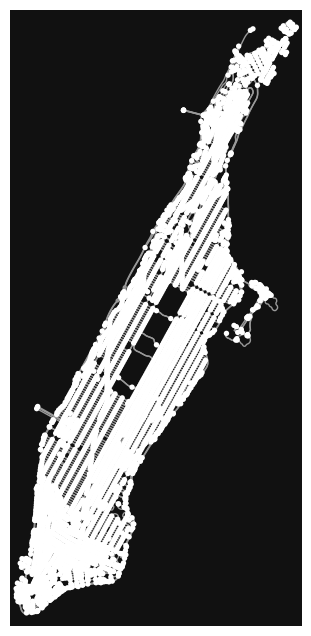

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [70]:
place = 'Manhattan, New York, USA'
G = ox.graph_from_place(place, network_type='drive')

ox.plot_graph(G)

In [35]:
nodes, streets = ox.graph_to_gdfs(G)
streets = streets.reset_index()
nodes = nodes.reset_index()

In [36]:
# find the coordinates for a location identified on google maps
x_specified = -73.985685
y_specified = 40.748578

def calculate_distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

nodes['distance'] = nodes.apply(lambda row: calculate_distance(x_specified, y_specified, row['x'], row['y']), axis=1)

nearest_coordinate = nodes.loc[nodes['distance'].idxmin()][['osmid']]
nearest_coordinate

osmid    42446701
Name: 2620, dtype: object

In [38]:
# function to get valid geometry neighbours only
def get_valid_neighbor(graph, node):
    neighbors = list(graph.neighbors(node))
    random.shuffle(neighbors)
    for neighbor in neighbors:
        if 'geometry' in graph[node][neighbor][0]:
            return neighbor
    return None

# random walks and steps
num_walks = 100
min_steps = 50
max_steps = 500
start_node = nearest_coordinate[0]
node_coords = nodes[nodes['osmid'] == start_node]['geometry']

# dict to count linestrings 
line_string_counts = {}  

# random walks loop
random_walks = []

for _ in range(num_walks):
    walk = [start_node]
    num_steps = random.randint(min_steps, max_steps)

    for _ in range(num_steps):
        current_node = walk[-1]
        neighbor = get_valid_neighbor(G, current_node)

        if neighbor is not None:
            walk.append(neighbor)
        else:
            # backtrack if no valid neighbor is found
            if len(walk) > 1:
                walk.pop()
            else:
                # break if there are no valid neighbors and we're at the start node
                break

    # linestrings between nodes
    line_strings = []
    for i in range(len(walk) - 1):
        start = walk[i]
        end = walk[i + 1]
        line = G[start][end][0]['geometry']
        line_str = str(line)
        if line_str not in line_string_counts:
            line_string_counts[line_str] = 0
        line_string_counts[line_str] += 1
        
        line_strings.append(line)

    random_walks.append(line_strings)

line_string_df = pd.DataFrame(line_string_counts.items(), columns=['LineString', 'Count'])


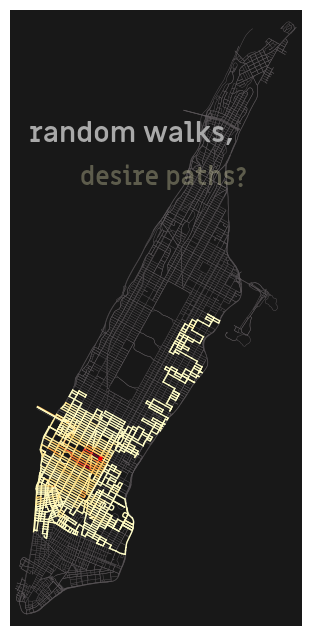

In [80]:
custom_font_path = 'c:/Windows/Fonts/MiriamLibre-Bold.otf'
custom_font = FontProperties(fname=custom_font_path)

fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, edge_color= '#5e595c', bgcolor='#181818', edge_linewidth=.3)

# color mapping based on number of occurrences
cmap = plt.get_cmap('YlOrRd')

max_count = line_string_df['Count'].max()
for _, row in line_string_df.iterrows():
    line_str = row['LineString']
    line = loads(line_str)  
    color = cmap(row['Count'] / max_count)
    x, y = line.xy
    ax.plot(x, y, linewidth=1, color=color)


# Add a text label to the middle of the figure
text_x = ((ax.get_xlim()[0] + ax.get_xlim()[1]) / 2) - .010
text_y = ((ax.get_ylim()[0] + ax.get_ylim()[1]) / 2) + .055

text_2_x = ((ax.get_xlim()[0] + ax.get_xlim()[1]) / 2) +.003
text_2_y = ((ax.get_ylim()[0] + ax.get_ylim()[1]) / 2) + .042

ax.text(text_x, text_y, 'random walks,', fontproperties=custom_font, color = 'darkgrey', fontsize=20, ha='center', va='center')
ax.text(text_2_x, text_2_y, 'desire paths?', fontproperties=custom_font, color = '#fffcc5', fontsize=18, ha='center', va='center', alpha = .3)

x, y = node_coords.x, node_coords.y
ax.plot(x, y, 'ro', markersize=2) 

plt.show()
fig.savefig("line_strings_plot.png", dpi=400)